# Ensemble techniques

#### Importing relevant libraries

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from os import system

### 1. Exploratory data quality report

In [86]:
# Importing data
data=pd.read_csv('../Data/bank-full.csv')

# a. Univariate analysis
print(data.shape) # Number of rows and columns in the dataframe
print(data.isnull().values.any()) # To check for null values in the dataframe
print(data.info()) # To check the data type of the columns of the dataframe
print(data.describe()) # To review the statistical summary of the dataframe
data.head()

(45211, 17)
False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
                age        balance           day      duration      campaign

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Insight: The object type columns needs to be converted to categorical type variables

In [87]:
# converting object type to categorical variables
for c in data.columns:
    if data[c].dtype=='object':
        data[c]=pd.Categorical(data[c])
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [88]:
# printing value counts of converted columns
print(data.job.value_counts()) # No particular order: One hot encoding
print(data.marital.value_counts())
print(data.education.value_counts())
print(data.default.value_counts())
print(data.housing.value_counts())
print(data.loan.value_counts())
print(data.contact.value_counts()) # No particular order: One hot encoding 
print(data.month.value_counts())
print(data.poutcome.value_counts())
print(data.Target.value_counts())

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64
unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64
n

In [89]:
# Constructing array for restructuring
rstruct={'marital':{'single':0, 'married':1, 'divorced':2}, 'education':{'unknown':-1,'primary':0,'secondary':1,'tertiary':2}, 'default':{'no':0, 'yes':1}, 'housing':{'no':0, 'yes':1}, 'loan':{'no':0, 'yes':1}, 'Target':{'no':0, 'yes':1}, 'poutcome':{'unknown':-1,'failure':0, 'success':1, 'other':2}, 'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
#rstruct={"marital":{"single":0, "married":1, "divorced":2}}
onehotcol=["job","contact"]

# Replacing bank data with new structure
data=data.replace(rstruct)
data=pd.get_dummies(data, columns=onehotcol)

In [90]:
# Visualizing modified dataframe 
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                45211 non-null  int64
 1   marital            45211 non-null  int64
 2   education          45211 non-null  int64
 3   default            45211 non-null  int64
 4   balance            45211 non-null  int64
 5   housing            45211 non-null  int64
 6   loan               45211 non-null  int64
 7   day                45211 non-null  int64
 8   month              45211 non-null  int64
 9   duration           45211 non-null  int64
 10  campaign           45211 non-null  int64
 11  pdays              45211 non-null  int64
 12  previous           45211 non-null  int64
 13  poutcome           45211 non-null  int64
 14  Target             45211 non-null  int64
 15  job_admin.         45211 non-null  uint8
 16  job_blue-collar    45211 non-null  uint8
 17  job_entrepre

,age,marital,education,default,balance,housing,loan,day,month,duration,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_cellular,contact_telephone,contact_unknown
0,58,1,2,0,2143,1,0,5,5,261,...,0,0,0,0,0,0,0,0,0,1
1,44,0,1,0,29,1,0,5,5,151,...,0,0,0,0,1,0,0,0,0,1
2,33,1,1,0,2,1,1,5,5,76,...,0,0,0,0,0,0,0,0,0,1
3,47,1,-1,0,1506,1,0,5,5,92,...,0,0,0,0,0,0,0,0,0,1
4,33,0,-1,0,1,0,0,5,5,198,...,0,0,0,0,0,0,1,0,0,1


Bivariate analysis



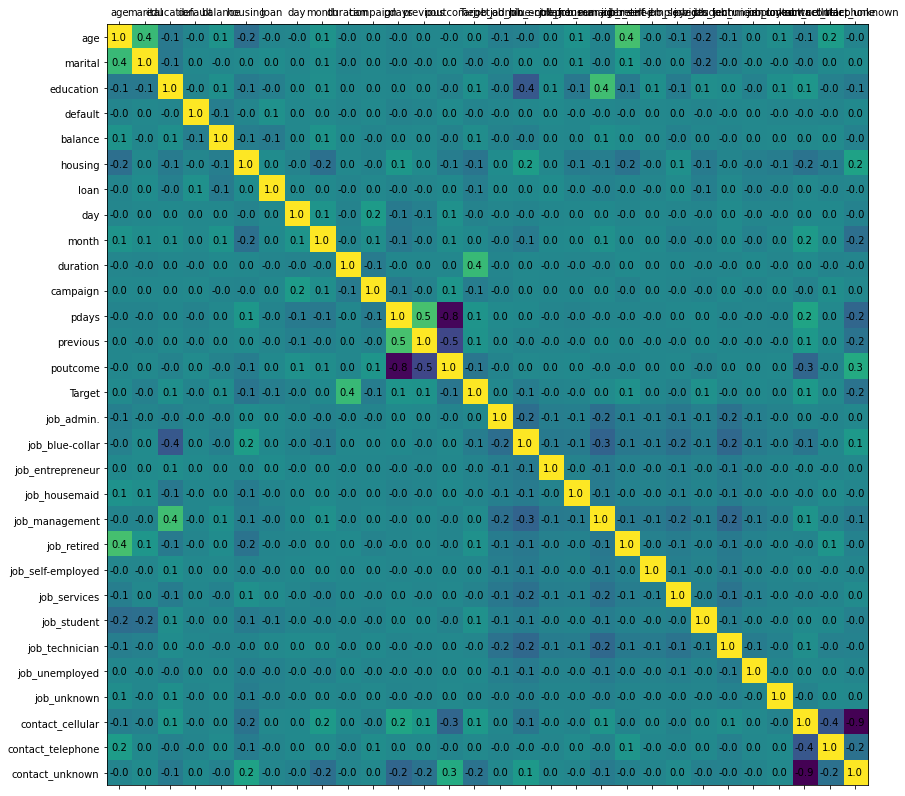

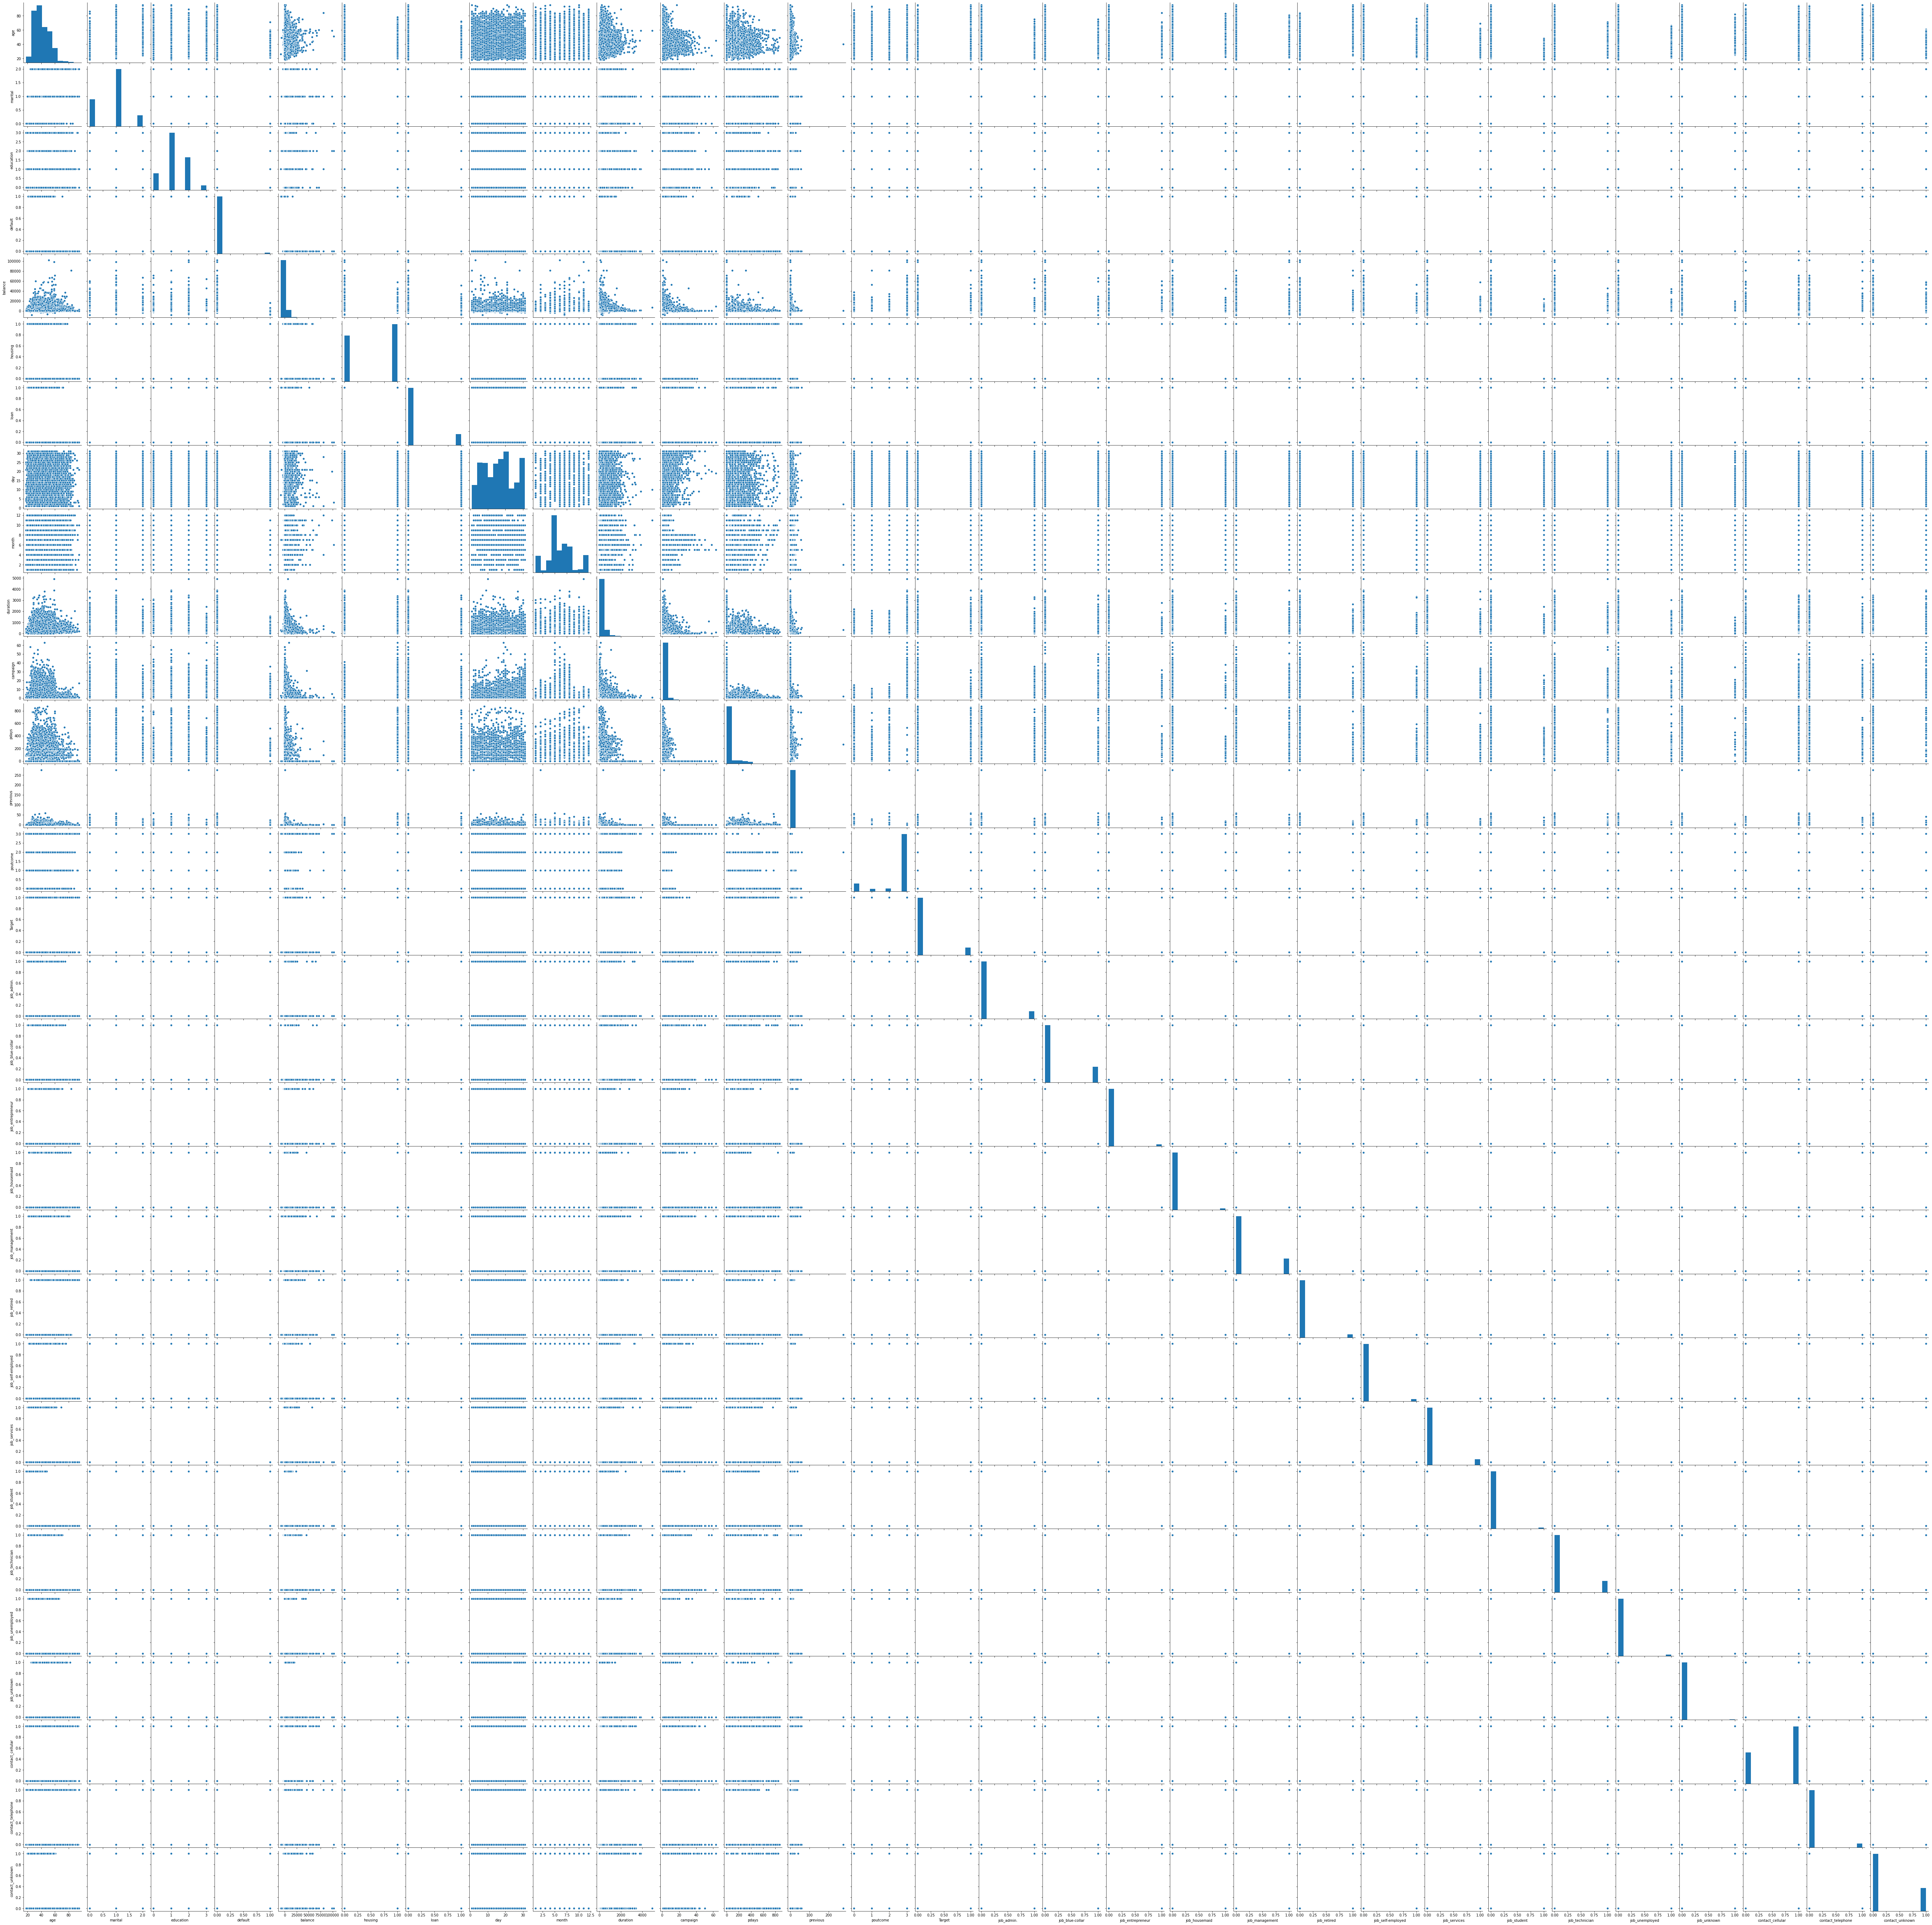

In [72]:
# Bivariate analysis
print('Bivariate analysis\n')
corr = data.corr()
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
sns.pairplot(data)

#### Insight: No two features are highly correlated. poutcome and pdays seem to be correlated only because unknown has been categorized as -1 which matches with that of -1 of pdays.